In [2]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import grad
from torch.autograd.functional import hessian
from torch.linalg import qr, svd, norm
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
def same_seed(seed):
    # set seeds
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

In [4]:
def incoherent_factor(n, r, mu):
    # Create a random orthonormal matrix
    Q, _ = qr(torch.randn((n, r)))
    row_norm2 = torch.sum(Q**2, axis=1)

    # choose the row we will 'spike'
    i_star = torch.randint(low=0, high=n, size=(1,))

    # 3. target norm^2 for the spike and for the rest
    target_spike = mu * r / n
    target_rest  = (r - target_spike) / (n - 1)

    # 4. rescale rows (then re-orthonormalise columns)
    scale = torch.sqrt(
        torch.where(
            torch.arange(n)==i_star,
            target_spike/row_norm2,
            target_rest/row_norm2
        )
    )
    U = (scale[:,None] * Q)

    # 5. final re-orthonormalisation (tiny tweak)
    U, _ = qr(U)         # keeps rows norms very close to target
    
    # Calculate the acutal coherence
    actual_mu = torch.max(torch.sum(U**2, axis=1) / (r / n))

    return U, actual_mu

In [5]:
def create_Z(n, m, r, mu, PSD=False):
    if PSD:
        assert n == m
        U, mu_U = incoherent_factor(n, r, mu)
        V, mu_V = U, mu_U
    else:
        U, mu_U = incoherent_factor(n, r, mu)
        V, mu_V = incoherent_factor(m, r, mu)
    s = torch.linspace(1.0, 0.2, r) 
    Sigma = torch.diag(s)
    Z = U @ Sigma @ V.T
    return Z, max(mu_U, mu_V)

In [6]:
def sample_mask(n, m, p):
    prob_mat = torch.zeros(n, m) + p
    mask = torch.bernoulli(prob_mat)
    return mask

In [7]:
def initialize(p, r, Z, mask):
    Z_0 = Z * mask * (1 / p)
    U, S, Vh = svd(Z_0, full_matrices=False)
    L_0 = U[:,:r] @ torch.diag(torch.sqrt(S[:r]))
    R_0 = Vh[:r,:].T @ torch.diag(torch.sqrt(S[:r]))
    # L_0 = torch.randn((Z.size(0), r))
    # R_0 = torch.randn((Z.size(1), r))
    return L_0.requires_grad_(True), R_0.requires_grad_(True)

In [8]:
def loss_fn(L, R, mask, Z):
    return torch.square(mask * (L @ R.T - Z)).sum()

In [9]:
@torch.no_grad()
def project(X, coherence):
    n, r = X.size()
    # incoherence projection of X
    row_norm_X = torch.linalg.vector_norm(X, ord=2, dim=1)
    frob_norm_X = torch.linalg.matrix_norm(X, ord='fro')
    row_norm_X.div_(frob_norm_X * np.sqrt(coherence / n))
    scale_X = torch.maximum(row_norm_X, torch.ones_like(row_norm_X))
    X.div_(scale_X.unsqueeze(-1))

In [10]:
def sgd(n, m, r, p, mu, PSD=False, projected=False, optim='SGD', iters=100, lr=0.001):
    # Initialization
    Z, mu_Z = create_Z(n, m, r, mu, PSD)
    mask = sample_mask(n, m, p)
    L, R = initialize(p, r, Z, mask)
    criterion = loss_fn
    if optim == 'SGD':
        optimizer = torch.optim.SGD([L, R], lr=lr, momentum=0.9)
    elif optim == 'Adam':
        optimizer = torch.optim.Adam([L, R], lr=lr, weight_decay=1e-4)
    else:
        raise NotImplementedError
    # SGD
    losses = []
    for i in tqdm(range(iters), leave=False):
        optimizer.zero_grad()
        loss = criterion(L, R, mask, Z)
        losses.append((loss.item()))
        loss.backward()
        optimizer.step()
        new_lr = 0.5 * (lr + 2e-5) + 0.5 * (lr - 2e-5) * np.cos(np.pi * i / iters)
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr
        # Project to feasible set
        if projected:
            project(L, mu)
            project(R, mu)
    
    w_L, h_L = L.size() 
    grad_norm_L = torch.linalg.matrix_norm(grad(criterion(L, R, mask, Z), L)[0])
    min_eigenvalue_L = torch.linalg.eigvalsh(hessian(criterion, (L, R, mask, Z))[0][0].reshape(w_L,h_L,-1).reshape(w_L*h_L,-1))[0]

    return L, R, Z, mu_Z, losses, torch.sum(mask).item(), torch.sum(((L @ R.T) - Z)**2).item(), grad_norm_L.item(), min_eigenvalue_L.item()

In [11]:
n   = 10
m   = 10
r   = 4
p   = 0.1
mu  = 2
PSD = False

projected = False
iters = 2000
lr = 0.001

same_seed(0)
L_star, R_star, Z, mu_Z, losses, samples, error = sgd(n, m, r, p, mu, PSD, projected, iters, lr)
print(losses[0], losses[-1])
print("==== Z ====")
print(Z)
print(f"mu_Z = {mu_Z}")
print("===== Samples ====")
print(f"{samples} / {n*m} of samples are drawn!")
print("==== Z* ====")
print(L_star @ R_star.T)
print("==== L* ====")
print(L_star)
print("==== R* ====")
print(R_star)
print("==== MSE ====")
print(error)


NotImplementedError: 

In [12]:
def plot_error(n, m, r, mu, PSD=False, projected=False, optim='SGD', iters=100, lr=0.001, data_points=20, ensemble=10):
    # Produce Error Data
    SE, FE, GN, MEI = [], [], [], []
    probs = np.linspace(0.1, 1, data_points)
    for p in probs:
        error, loss, grad, eigen = 0, 0, 0, 0
        for i in range(ensemble):
            _, _, _, _, _losses, _, _error, grad_norm, min_eigen = sgd(n, m, r, p, mu, PSD, projected, optim, iters, lr)
            error += _error
            loss += _losses[-1]
            grad += grad_norm
            eigen += min_eigen
        SE.append(error / ensemble)
        FE.append(loss / ensemble)
        GN.append(grad_norm / ensemble)
        MEI.append(eigen / ensemble)
    
    # bound = mu * r * (np.log10(n))**2 / n
    # Plotting
    fig, ax = plt.subplots(2, 2, figsize=(20, 20), tight_layout=True)
    
    ax[0][0].plot(probs, SE, marker='o', linestyle='-', color='blue', label='empirical data')
    ax[0][1].plot(probs, FE, marker='o', linestyle='-', color='blue', label='empirical data')
    ax[1][0].plot(probs, GN, marker='o', linestyle='-', color='blue', label='empirical data')
    ax[1][1].plot(probs, MEI, marker='o', linestyle='-', color='blue', label='empirical data')
    # ax.axvline(x = bound, color = 'r', label = 'theoretical bound')
    
    ax[0][0].set_xlabel("Sample Probability p", fontsize=30), 
    ax[0][0].set_ylabel(r"$\|L_tR_t^T - Z\|^2_F$", fontsize=30)
    ax[0][0].set_title(f"Impact of p on Solution Exactness", fontsize=25, fontname='Comic Sans MS')
    ax[0][0].xaxis.set_tick_params(labelsize=20)
    ax[0][0].yaxis.set_tick_params(labelsize=20)
    ax[0][0].set_yscale('log')
    ax[0][0].grid()

    ax[0][1].set_xlabel("Sample Probability p", fontsize=30), 
    ax[0][1].set_ylabel(r"$f(L_t, R_t)$", fontsize=30)
    ax[0][1].set_title(f"Impact of p on Global Optimality", fontsize=25, fontname='Comic Sans MS')
    ax[0][1].xaxis.set_tick_params(labelsize=20)
    ax[0][1].yaxis.set_tick_params(labelsize=20)
    ax[0][1].set_yscale('log')
    ax[0][1].grid()

    ax[1][0].set_xlabel("Sample Probability p", fontsize=30), 
    ax[1][0].set_ylabel(r"$\|\nabla_L f(L_t,R_t)\|^2_F$", fontsize=30)
    ax[1][0].set_title(f"Final Gradient Norm", fontsize=25, fontname='Comic Sans MS')
    ax[1][0].xaxis.set_tick_params(labelsize=20)
    ax[1][0].yaxis.set_tick_params(labelsize=20)
    ax[1][0].set_yscale('log')
    ax[1][0].grid()

    ax[1][1].set_xlabel("Sample Probability p", fontsize=30), 
    ax[1][1].set_ylabel(r"$\lambda_{min}(\nabla^2_Lf(L_t,R_t))$", fontsize=30)
    ax[1][1].set_title(f"Final Minimum Eigenvalue", fontsize=25, fontname='Comic Sans MS')
    ax[1][1].xaxis.set_tick_params(labelsize=20)
    ax[1][1].yaxis.set_tick_params(labelsize=20)
    # ax[1][1].set_yscale('log')
    ax[1][1].grid()

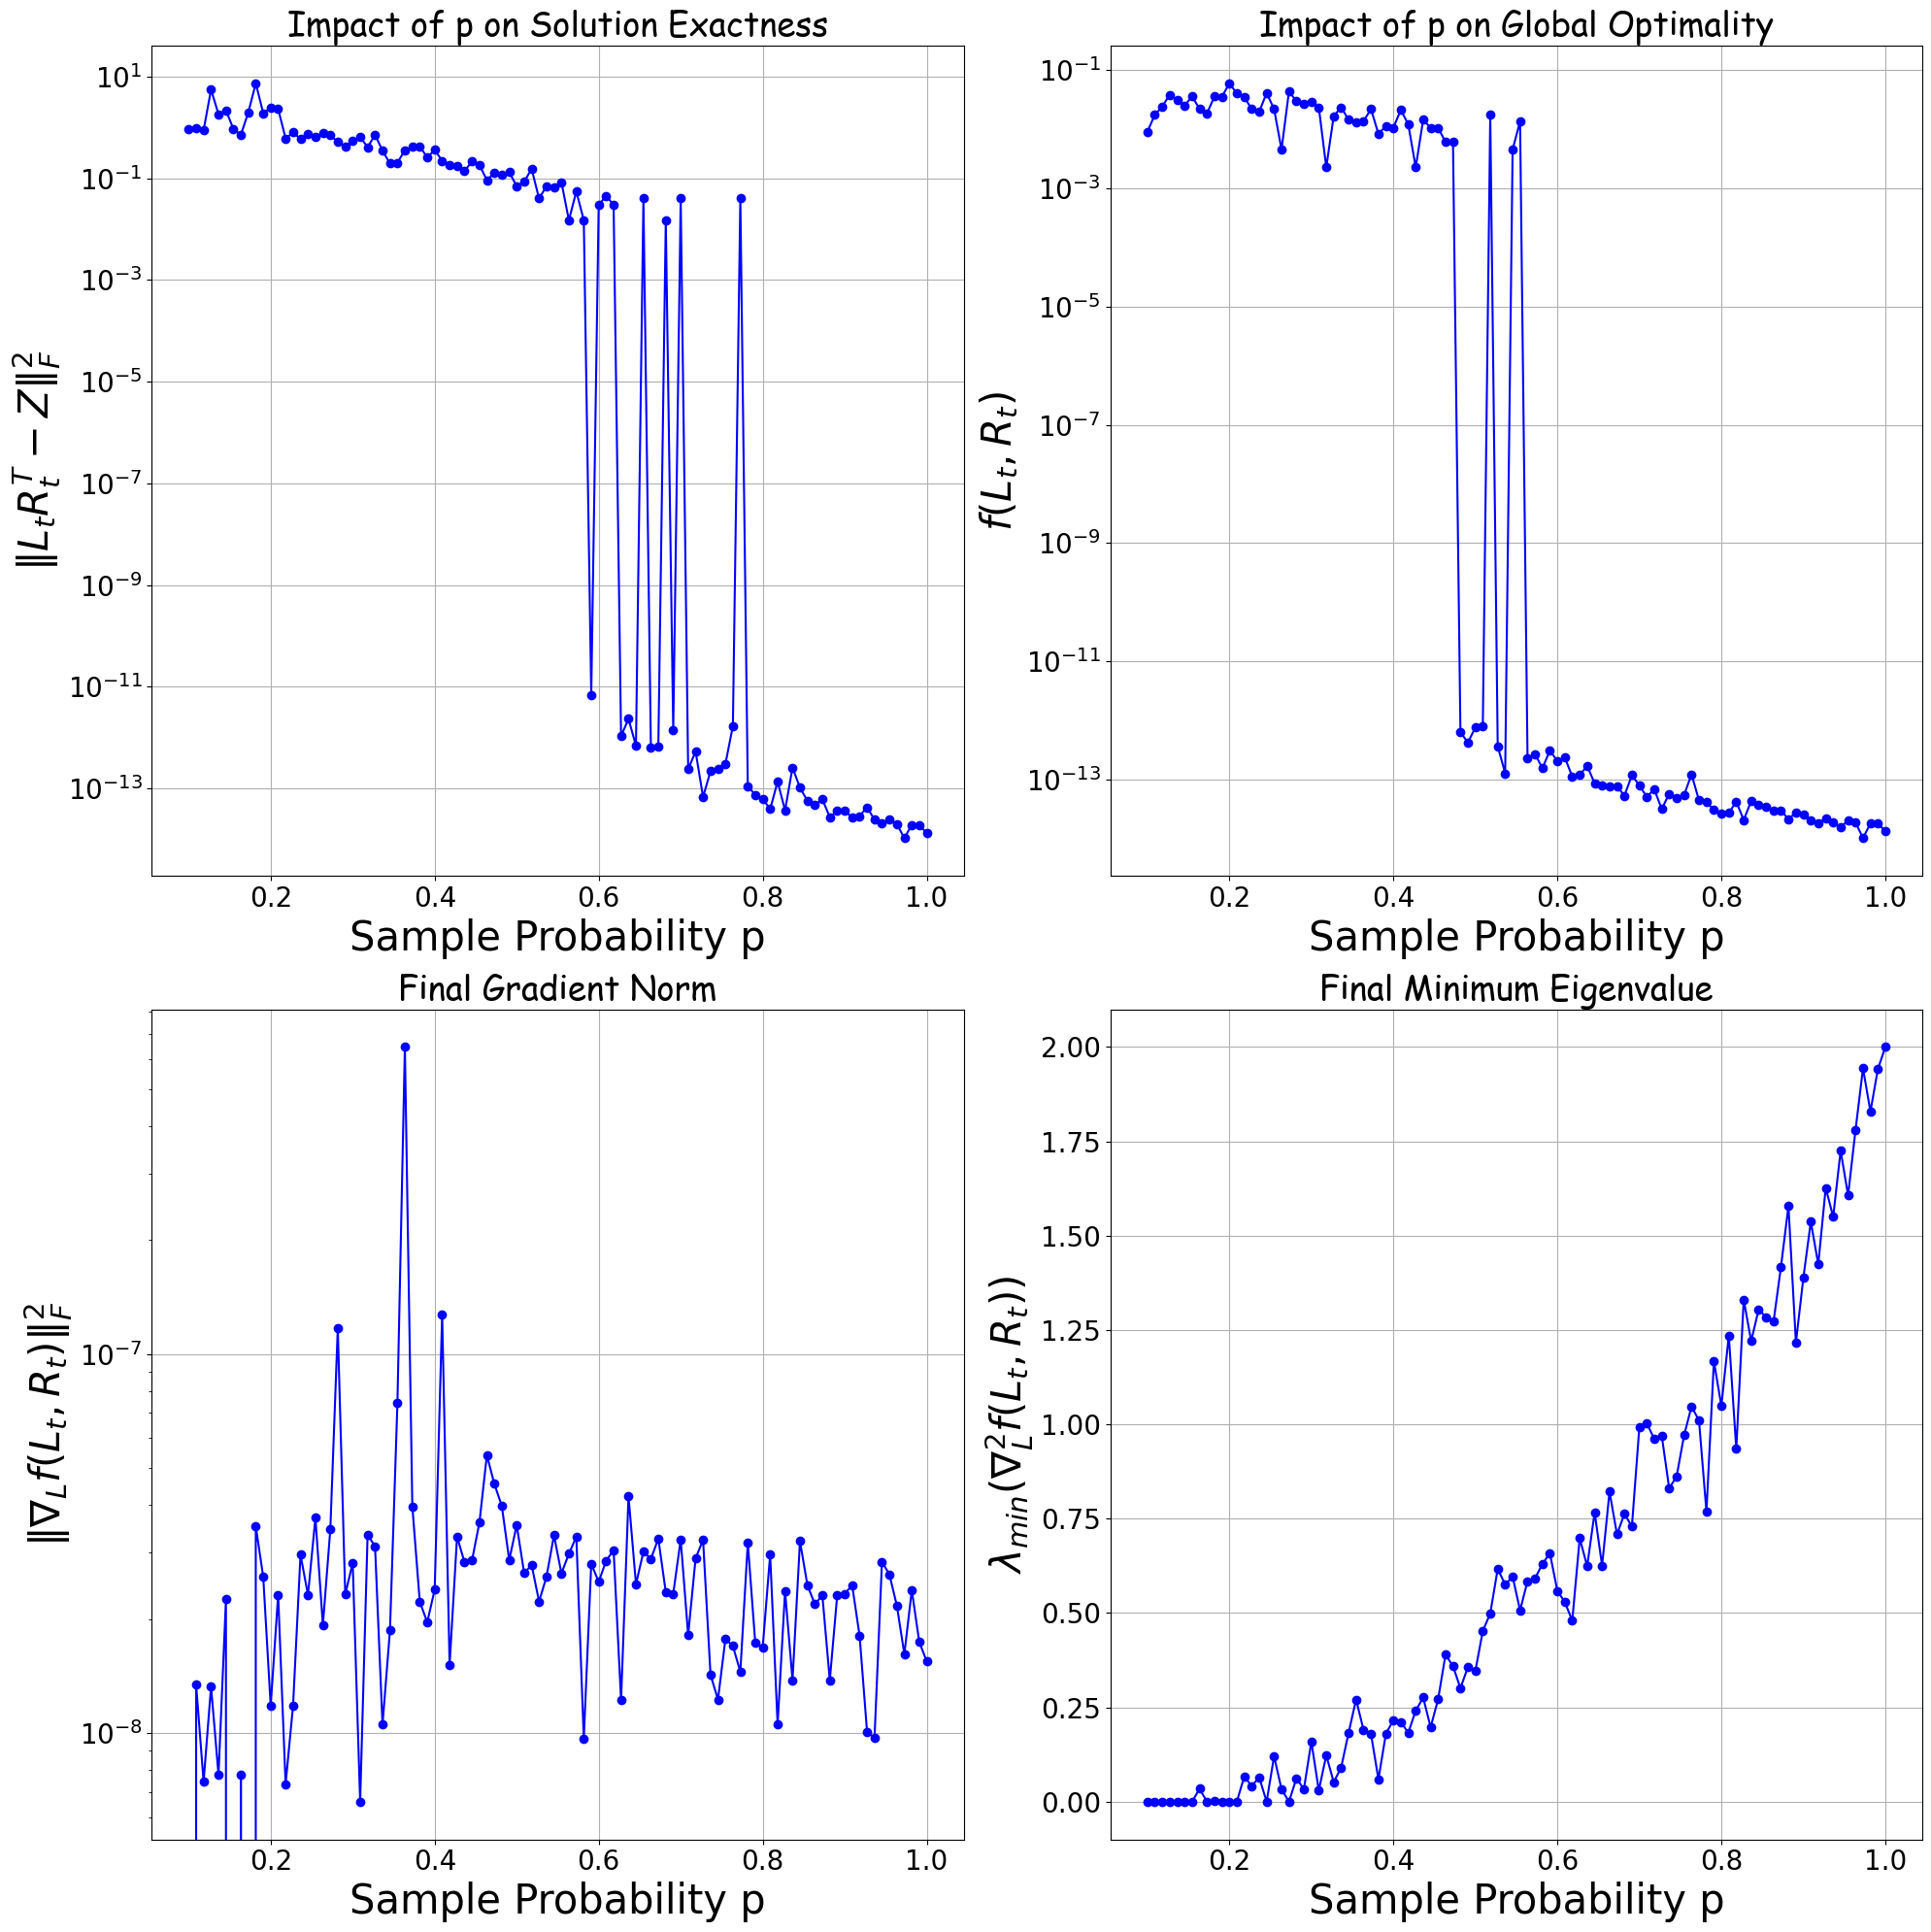

In [16]:
n   = 5
m   = 5
r   = 1
mu  = 2
PSD = True

projected = False
iters = 5000
lr = 0.01

data_points = 100
ensemble = 10
optim = 'SGD'

same_seed(0)
plot_error(n, m, r, mu, PSD, projected, optim, iters, lr, data_points, ensemble)